In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def gamma2v (gamma):
    return np.sqrt(1.-1./(gamma**2))
def v2gamma (v):
    return 1./np.sqrt(1.-v**2)

In [61]:
# From Drappeau (2015) for GX339-4
rel_rms = 0.356 # RMS(d(gamma-1))/(<gamma>-1)
gamma_j = np.array([1.5,2,4])
# we have selected 2 in our estimations (see Overleaf)
gamma_j = 2.0

In [72]:
# calculate the speeds of two shells each rms away from the mean flow speed
gamma_sh = np.array([(2.0+rel_rms) * (gamma_j-1.0), (2.0-rel_rms) * (gamma_j-1.0)])
v_sh = gamma2v(gamma_sh)
print(gamma_sh)
print(v_sh)

[2.356 1.644]
[0.90545221 0.79372826]


In [73]:
# transform to the center-of-momentum frame
v_com = np.sum(gamma_sh*v_sh) / np.sum(gamma_sh)
print(v_com)
v_sh_com = (v_sh-v_com) / (1.0 - v_sh*v_com)
print(v_sh_com)
gamma_sh_com = v2gamma(v_sh_com)
print(gamma_sh_com)

0.8595336705469252
[ 0.20708904 -0.20708904]
[1.02215824 1.02215824]


In [74]:
# what is the relative speed of the shells
v_rel = (v_sh[1]-v_sh[0]) / (1.0 - np.product(v_sh))
print(v_rel)
gamma_rel = v2gamma(v_rel)
print(gamma_rel)

-0.3971461173219567
1.0896149535690385


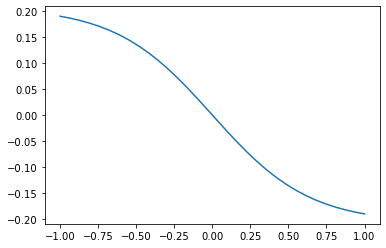

In [79]:
def sigmoid (x):
    return 1./(1.+np.exp(-x))

spread = 2.
x = np.linspace(-0.5*spread, 0.5*spread, 32)
y = sigmoid(x*(2.*np.pi/spread)) * (v_sh_com[1]-v_sh_com[0]) + v_sh_com[0]

plt.plot(x,y)
plt.show()
plt.close()